# Kaggle Competition: Acea Smart Water Analysis
https://www.kaggle.com/c/acea-water-prediction/
## Challenge
Can you build a story to predict the amount of water in each unique waterbody? The challenge is to determine how features influence the water availability of each presented waterbody. To be more straightforward, gaining a better understanding of volumes, they will be able to ensure water availability for each time interval of the year.

https://www.kaggle.com/xueyingzhao009/time-series-analysis-acea-smart-water-analysis

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore
import matplotlib.dates as mdates

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split ## !pip install sklearn

from datetime import datetime, date 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data\Aquifer_Auser.csv
./data\Aquifer_Doganella.csv
./data\Aquifer_Luco.csv
./data\Aquifer_Petrignano.csv
./data\CI Alert Model-priority.csv
./data\datasets_description.ods
./data\Lake_Bilancino.csv
./data\River_Arno.csv
./data\Water_Spring_Amiata.csv
./data\Water_Spring_Lupa.csv
./data\Water_Spring_Madonna_di_Canneto.csv


I will build model to predict the depth to groundwater of an aquifer located in Petrignano, Italy. The question I want to ask is :

- What is the future depth to groundwater of a well belonging to the aquifier in Petrigrano over the next quarter?
- What do features influence the water availability of in the aquifer?

Petrignano Aquifer Description: The wells field of the alluvial plain between Ospedalicchio di Bastia Umbra and Petrignano is fed by three underground aquifers separated by low permeability septa. The aquifer can be considered a water table groundwater and is also fed by the Chiascio river. The groundwater levels are influenced by the following parameters: rainfall, depth to groundwater, temperatures and drainage volumes, level of the Chiascio river.

In [18]:
df = pd.read_csv("./data/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


In [21]:
df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  5223 non-null   datetime64[ns]
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64       
 2   Depth_to_Groundwater_P24              5168 non-null   float64       
 3   Depth_to_Groundwater_P25              5184 non-null   float64       
 4   Temperature_Bastia_Umbra              4199 non-null   float64       
 5   Temperature_Petrignano                4199 non-null   float64       
 6   Volume_C10_Petrignano                 5025 non-null   float64       
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 326.6 KB


In [22]:
print('The earliest date: \t%s' %df['Date'].values[[0, -1]][0])
print('The latest date: \t%s' %df['Date'].values[[0, -1]][1])
print(df.shape)

The earliest date: 	2006-03-14T00:00:00.000000000
The latest date: 	2020-06-30T00:00:00.000000000
(5223, 8)


In [23]:
feature_col=list(df.columns[1:])
feature_col

['Rainfall_Bastia_Umbra',
 'Depth_to_Groundwater_P24',
 'Depth_to_Groundwater_P25',
 'Temperature_Bastia_Umbra',
 'Temperature_Petrignano',
 'Volume_C10_Petrignano',
 'Hydrometry_Fiume_Chiascio_Petrignano']

## Data Visualization

In [25]:
len(feature_col)-2

5

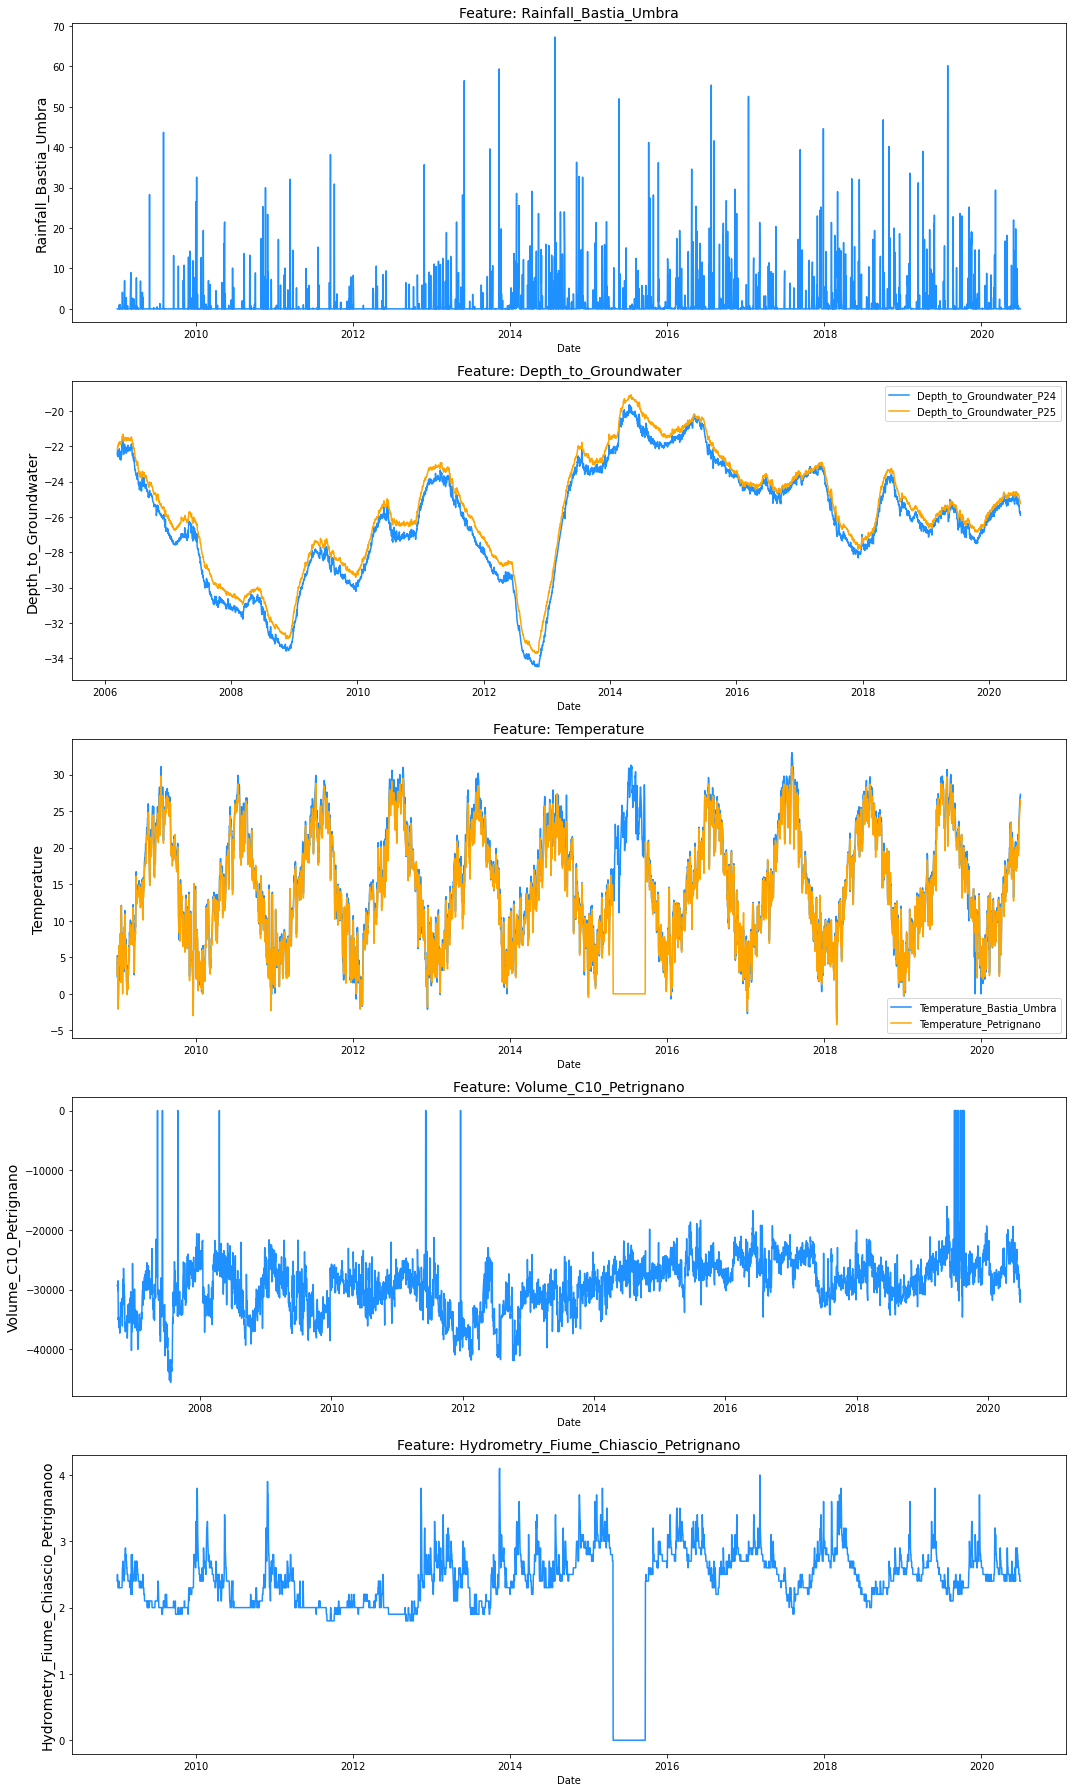

In [30]:
f, ax = plt.subplots(nrows=len(feature_col)-2, ncols=1, figsize=(15, 25))

## Plot Rainfall Bastia Umbria
sns.lineplot(x=df['Date'].where(df['Rainfall_Bastia_Umbra'].notnull()), 
             y=df['Rainfall_Bastia_Umbra'].fillna(np.inf), 
             ax=ax[0], 
             color='dodgerblue')
ax[0].set_title('Feature: {}'.format('Rainfall_Bastia_Umbra'), fontsize=14)
ax[0].set_ylabel(ylabel='Rainfall_Bastia_Umbra', fontsize=14) 

## Plot Depth_to_Groundwater (24 and 25)
sns.lineplot(x=df['Date'].where(df['Depth_to_Groundwater_P24'].notnull()), 
             y=df['Depth_to_Groundwater_P24'].fillna(np.inf), 
             ax=ax[1], 
             color='dodgerblue',
             label='Depth_to_Groundwater_P24')
sns.lineplot(x=df['Date'].where(df['Depth_to_Groundwater_P25'].notnull()), 
             y=df['Depth_to_Groundwater_P25'].fillna(np.inf), 
             ax=ax[1], 
             color='orange',
             label='Depth_to_Groundwater_P25')
ax[1].set_title('Feature: {}'.format('Depth_to_Groundwater'), fontsize=14)
ax[1].set_ylabel(ylabel='Depth_to_Groundwater', fontsize=14)

## Plot Temperature_Bastia_Umbra and Temperature_Petrignano
sns.lineplot(x=df['Date'].where(df['Temperature_Bastia_Umbra'].notnull()), 
             y=df['Temperature_Bastia_Umbra'].fillna(np.inf), 
             ax=ax[2], 
             color='dodgerblue',
             label='Temperature_Bastia_Umbra')
sns.lineplot(x=df['Date'].where(df['Temperature_Petrignano'].notnull()), 
             y=df['Temperature_Petrignano'].fillna(np.inf), 
             ax=ax[2], 
             color='orange',
             label='Temperature_Petrignano')
ax[2].set_title('Feature: {}'.format('Temperature'), fontsize=14)
ax[2].set_ylabel(ylabel='Temperature', fontsize=14)

## Plot Volume
sns.lineplot(x=df['Date'].where(df['Volume_C10_Petrignano'].notnull()), 
             y=df['Volume_C10_Petrignano'].fillna(np.inf), 
             ax=ax[3], 
             color='dodgerblue')
ax[3].set_title('Feature: {}'.format('Volume_C10_Petrignano'), fontsize=14)
ax[3].set_ylabel(ylabel='Volume_C10_Petrignano', fontsize=14)

## Plot Hydrometry
sns.lineplot(x=df['Date'].where(df['Hydrometry_Fiume_Chiascio_Petrignano'].notnull()), 
             y=df['Hydrometry_Fiume_Chiascio_Petrignano'].fillna(np.inf), 
             ax=ax[4], 
             color='dodgerblue')
ax[4].set_title('Feature: {}'.format('Hydrometry_Fiume_Chiascio_Petrignano'), fontsize=14)
ax[4].set_ylabel(ylabel='Hydrometry_Fiume_Chiascio_Petrignanoo', fontsize=14)

plt.tight_layout()
plt.show()

In [32]:
corrmat

,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
Rainfall_Bastia_Umbra,1.000000,0.075098,0.067708,-0.052813,-0.037148,0.136405,0.141373
Depth_to_Groundwater_P24,0.075098,1.000000,0.997506,0.097207,-0.051347,0.357537,0.022641
Depth_to_Groundwater_P25,0.067708,0.997506,1.000000,0.117417,-0.034472,0.325056,0.000276
Temperature_Bastia_Umbra,-0.052813,0.097207,0.117417,1.000000,0.835754,-0.069267,-0.434575
Temperature_Petrignano,-0.037148,-0.051347,-0.034472,0.835754,1.000000,-0.121420,0.006203
Volume_C10_Petrignano,0.136405,0.357537,0.325056,-0.069267,-0.121420,1.000000,0.216617
Hydrometry_Fiume_Chiascio_Petrignano,0.141373,0.022641,0.000276,-0.434575,0.006203,0.216617,1.000000


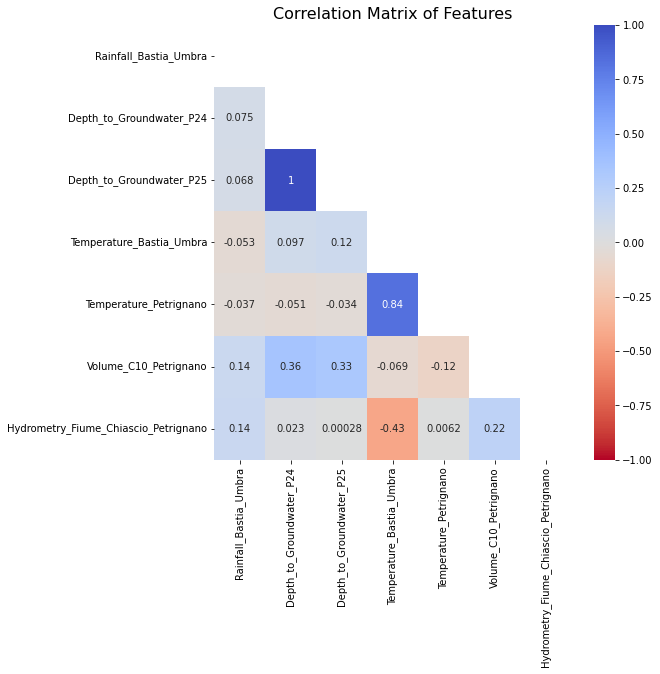

In [35]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

corrmat = df[feature_col].corr()
mask = np.triu(np.ones_like(corrmat, dtype=np.bool))
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax, mask=mask)
ax.set_title('Correlation Matrix of Features', fontsize=16)

plt.show()

Temperature Petrignano and Temperature Bastia Umbra are identical. And Temperature Petrignano has missing values. So I will keep Temperature Bastia Umbra.

'Depth_to_Groundwater_P24' and 'Depth_to_Groundwater_P25' are also identical. For the simplicity, I keep 'Depth_to_Groundwater_P25' as target.

Drainage volume has the highest correlation with the target-Depth_to_Groundwater.

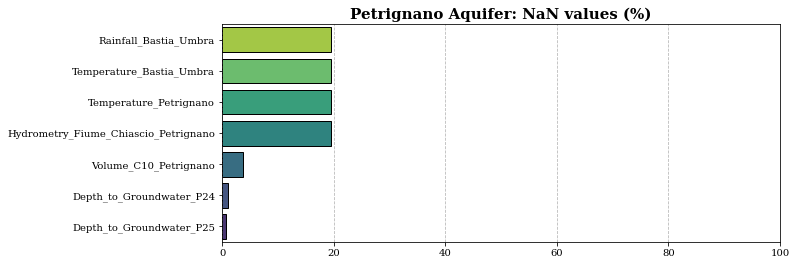

In [36]:
#Check missing values
NaN_values = (df[feature_col].isnull().sum() / len(df) * 100).sort_values(ascending = False)

fig, ax = plt.subplots(figsize = (10, 4))
plt.title('Petrignano Aquifer: NaN values (%)', size = 15, fontweight = 'bold', fontfamily = 'serif')
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
sns.barplot(x = NaN_values, y = NaN_values.index, edgecolor = 'black', ax = ax,
                palette = reversed(sns.color_palette("viridis", len(NaN_values.index))))
ax.set_xlim((0, 100))    
ax.set_xticklabels(range(0, 101, 20), fontfamily = 'serif')
ax.set_yticklabels(NaN_values.index, fontfamily = 'serif')
ax.grid(axis = 'x', linestyle = '--', alpha = 0.9)
plt.show()

In [37]:
df.shape

(5223, 8)

In [38]:
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,2006-03-14,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,2006-03-15,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,2006-03-16,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,2006-03-17,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,2006-03-18,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [39]:
# Reset date using rainfall data which has a shorter duration
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [40]:
# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']
targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


**Features**:

- **Rainfall** indicates the quantity of rain falling (mm)
- **Temperature** indicates the temperature (°C)
- **Drainage_Volume** indicates the volume of water taken from the drinking water treatment plant (m^3 )
- **River_Hydrometry** indicates the groundwater level (m)

**Target**:

- **Depth to Groundwater** indicates the groundwater level (m from the ground floor)

In [41]:
print('The earliest date: \t%s' %df['Date'].values[0])
print('The latest date: \t%s' %df['Date'].values[-1])
print(df.shape)

The earliest date: 	2009-01-01T00:00:00.000000000
The latest date: 	2020-06-30T00:00:00.000000000
(4199, 6)


## Data Preprocessing
### Chronological Order and Equidistant Timestamps
The data should be in chronological order and the timestamps should be equidistant in time series.

In [42]:
df = df.sort_values(by='Date')

df['Time_Interval'] = df['Date'] - df['Date'].shift(1)

df[['Date', 'Time_Interval']].head()

,Date,Time_Interval
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [44]:
print(f"{df['Time_Interval'].value_counts()}")
df = df.drop('Time_Interval', axis=1)

1 days    4198
Name: Time_Interval, dtype: int64


The time interval is one day and the data is already in chronological order.

### Handling Missing Data

In [45]:
df.isna().sum()

Date                     0
Rainfall                 0
Depth_to_Groundwater    27
Temperature              0
Drainage_Volume          1
River_Hydrometry         0
dtype: int64